2025-08-01 01:11:29 — INFO — Notebook start.
2025-08-01 01:11:29 — INFO — Installing python-dotenv (missing)
2025-08-01 01:11:30 — INFO — Installing Pillow (missing)
2025-08-01 01:11:33 — INFO — GenAI backend: Dev API
2025-08-01 01:11:33 — INFO — REFUGE2 dataset found at D:\Projects\gemini_image_segmentation\data\REFUGE2
2025-08-01 01:11:33 — INFO — 800 paired images collected.
2025-08-01 01:11:33 — INFO — Selected sample image: g0010.jpg
2025-08-01 01:11:33 — INFO — Starting Gemini API call for fundus image.
2025-08-01 01:11:33 — INFO — Resized image from 2124x2056 to (1024, 991) for API call.
2025-08-01 01:11:33 — INFO — AFC is enabled with max remote calls: 10.
2025-08-01 01:11:39 — INFO — HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-08-01 01:11:39 — INFO — AFC remote call 1 is done.
2025-08-01 01:11:39 — INFO — Gemini latency 6.42s
2025-08-01 01:11:39 — INFO — Received response from Gemini. Parsin

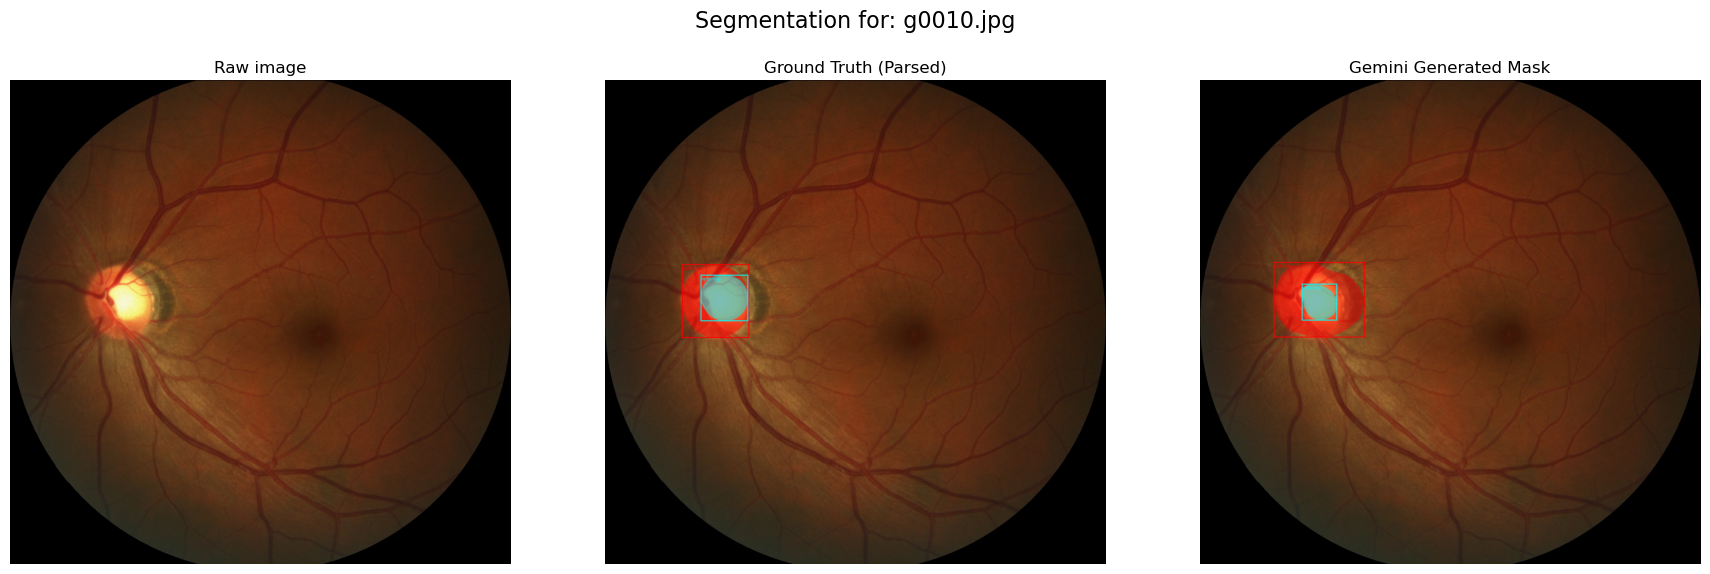

'\n✅ Environment verified, REFUGE2 dataset indexed, Gemini smoke-test executed.\nThe ground truth mask is now parsed and visualized in the same manner as the\nGemini output for a direct comparison.\n'

In [1]:
# %% [markdown]
"""
# 0 Environment & Data Prep · **Optic Disc/Cup Segmentation**

*Last sync 01 Aug 2025* This script is adapted for segmenting the optic disc and cup from
retinal fundus images using the Gemini API.

**Changelog (Refactored for Fundus Segmentation)**
* **MODIFIED** Dataset path to target `data/REFUGE2`.
* **MODIFIED** File collection logic to pair images (.jpg) and masks (.bmp) by their common filename stem.
* **MODIFIED** The Gemini prompt to request segmentation of the "optic disc" and "optic cup".
* **ADDED** A new function `parse_ground_truth_mask` to extract separate masks for the disc and cup from the color-coded `.bmp` file. This allows for an apples-to-apples visualization comparison.
* **REMOVED** The batch preparation logic (pilot list creation).
* **UPDATED** Comments and logging to reflect the new task.
"""

# %%
# ---------- Preamble
import sys, logging, os, subprocess, importlib.util, json, io, random, base64, dataclasses
from datetime import datetime
from pathlib import Path
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageColor, UnidentifiedImageError

assert sys.version_info >= (3, 11), (
    f"Python 3.11+ required, found {sys.version.split()[0]}")

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s — %(levelname)s — %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logging.info("Notebook start.")

# %%
# ---------- Ensure helper packages

def _ensure(pkg: str):
    """Checks if a package is installed and installs it if not."""
    if importlib.util.find_spec(pkg) is None:
        logging.info("Installing %s (missing)", pkg)
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "--quiet"])

for extra in ("python-dotenv", "tqdm", "matplotlib", "numpy", "Pillow"):
    _ensure(extra)

# %%
# ---------- GenAI client
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=False)

from google import genai
from google.genai.types import GenerateContentConfig, Part, ThinkingConfig

if not os.getenv("GOOGLE_API_KEY"):
    raise ValueError("GOOGLE_API_KEY not found. Ensure it is in your .env file.")

client = genai.Client()
logging.info("GenAI backend: %s", "Vertex" if client.vertexai else "Dev API")

# %%
# ---------- Dataset paths
# The script now points to the REFUGE2 dataset directory.
dataset_dir = Path(os.getenv("REFUGE_DIR", "data/REFUGE2")).expanduser().resolve()
image_dir = dataset_dir / "image"
mask_dir = dataset_dir / "mask"

if not (dataset_dir.is_dir() and image_dir.is_dir() and mask_dir.is_dir()):
    logging.error("Dataset not found or incomplete at the specified path.")
    raise FileNotFoundError(
        f"Expected 'image/' & 'mask/' subdirectories inside {dataset_dir}. "
        "Please set the REFUGE_DIR environment variable correctly."
    )
logging.info("REFUGE2 dataset found at %s", dataset_dir)


# %%
# ---------- Collect pairs
# Logic is updated to match image stems (e.g., 'g0001.jpg' with 'g0001.bmp').
img_paths = sorted(image_dir.glob("*.jpg"))
mask_map  = {p.stem: p for p in mask_dir.glob("*.bmp")}

dataset = [(img, mask_map[img.stem]) for img in img_paths if img.stem in mask_map]
assert dataset, "No image-mask pairs found in the dataset!"
logging.info("%d paired images collected.", len(dataset))


# %%
# ---------- Segmentation Utils

@dataclasses.dataclass(frozen=True)
class SegmentationMask:
    """A dataclass to hold a single segmentation mask's data."""
    y0: int
    x0: int
    y1: int
    x1: int
    mask: np.ndarray # Full-size mask [img_height, img_width] with values 0..255
    label: str

def parse_json(json_output: str) -> str:
    """Cleans the model's JSON output by removing markdown fencing."""
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line.strip() == "```json":
            json_content = "\n".join(lines[i+1:])
            closing_fence_index = json_content.find("```")
            if closing_fence_index != -1:
                json_content = json_content[:closing_fence_index]
            return json_content.strip()
    return json_output.strip()

def parse_segmentation_masks(
    predicted_str: str, *, img_height: int, img_width: int
) -> list[SegmentationMask]:
    """Parses the model's JSON output into a list of SegmentationMask objects."""
    cleaned_json = parse_json(predicted_str)
    if not cleaned_json:
        logging.warning("Parsing model output resulted in an empty string.")
        return []

    try:
        items = json.loads(cleaned_json)
    except json.JSONDecodeError as e:
        logging.error(f"Failed to decode JSON: {e}")
        logging.error(f"Problematic string after cleaning: {cleaned_json}")
        return []

    masks = []
    for item in items:
        try:
            abs_y0 = int(item["box_2d"][0] / 1000 * img_height)
            abs_x0 = int(item["box_2d"][1] / 1000 * img_width)
            abs_y1 = int(item["box_2d"][2] / 1000 * img_height)
            abs_x1 = int(item["box_2d"][3] / 1000 * img_width)

            if abs_y0 >= abs_y1 or abs_x0 >= abs_x1:
                logging.warning("Skipping item with invalid bounding box: %s", item["box_2d"])
                continue

            label = item["label"]
            png_b64_str = item["mask"]

            if not png_b64_str.startswith("data:image/png;base64,"):
                logging.warning("Skipping item with invalid mask format for label '%s'", label)
                continue

            png_bytes = base64.b64decode(png_b64_str.removeprefix("data:image/png;base64,"))
            partial_mask_img = Image.open(io.BytesIO(png_bytes))

            bbox_height = abs_y1 - abs_y0
            bbox_width = abs_x1 - abs_x0
            if bbox_height < 1 or bbox_width < 1:
                logging.warning("Skipping item with zero-area bounding box for label '%s'", label)
                continue

            resized_mask = partial_mask_img.resize((bbox_width, bbox_height), resample=Image.Resampling.BILINEAR)
            full_mask_np = np.zeros((img_height, img_width), dtype=np.uint8)
            full_mask_np[abs_y0:abs_y1, abs_x0:abs_x1] = np.array(resized_mask)

            masks.append(SegmentationMask(abs_y0, abs_x0, abs_y1, abs_x1, full_mask_np, label))
        except (KeyError, IndexError, TypeError, base64.binascii.Error, UnidentifiedImageError) as e:
            logging.error(f"Skipping malformed item in JSON response: {item}. Error: {e}")
            continue
    return masks

def parse_ground_truth_mask(mask_path: Path) -> list[SegmentationMask]:
    """
    Parses a REFUGE2 ground truth BMP file into separate SegmentationMasks for disc and cup.
    The BMP file uses specific colors:
    - Optic Cup: Black (0, 0, 0)
    - Optic Disc Ring: Gray (128, 128, 128)
    - Background: White (255, 255, 255)
    """
    try:
        mask_img = Image.open(mask_path).convert("RGB")
        mask_data = np.array(mask_img)
    except (FileNotFoundError, UnidentifiedImageError) as e:
        logging.error("Could not read or identify ground truth mask file %s: %s", mask_path, e)
        return []

    # Define colors
    CUP_COLOR = np.array([0, 0, 0])
    DISC_COLOR = np.array([128, 128, 128])

    # Create binary masks
    is_cup = np.all(mask_data == CUP_COLOR, axis=-1)
    is_disc_ring = np.all(mask_data == DISC_COLOR, axis=-1)
    is_disc = is_cup | is_disc_ring # The full disc is the cup + the surrounding ring

    masks = []
    for label, binary_mask_data in [("optic cup", is_cup), ("optic disc", is_disc)]:
        if not np.any(binary_mask_data):
            continue # Skip if this class isn't in the mask

        # Find bounding box from the binary mask
        rows, cols = np.where(binary_mask_data)
        y0, y1 = rows.min(), rows.max()
        x0, x1 = cols.min(), cols.max()

        # Convert boolean mask to uint8 (0-255) for visualization
        full_mask_np = binary_mask_data.astype(np.uint8) * 255

        masks.append(SegmentationMask(y0, x0, y1, x1, full_mask_np, label))

    # Ensure disc is first for consistent coloring
    masks.sort(key=lambda m: m.label, reverse=True)
    return masks


def overlay_mask_on_img(img: Image.Image, mask: np.ndarray, color: str, alpha: float = 0.5) -> Image.Image:
    """Overlays a single mask onto a PIL Image."""
    color_rgb = ImageColor.getrgb(color)
    img_rgba = img.convert("RGBA")
    overlay_color_rgba = color_rgb + (int(alpha * 255),)

    colored_mask_layer_np = np.zeros((img.height, img.width, 4), dtype=np.uint8)
    mask_binary = mask > 127
    colored_mask_layer_np[mask_binary] = overlay_color_rgba
    colored_mask_layer_pil = Image.fromarray(colored_mask_layer_np)

    return Image.alpha_composite(img_rgba, colored_mask_layer_pil)

def plot_segmentation_masks(img: Image.Image, segmentation_masks: list[SegmentationMask]) -> Image.Image:
    """Draws all masks, bounding boxes, and labels on an image."""
    if not segmentation_masks:
        return img.convert("RGB")

    colors = ["red", "cyan", "blue", "yellow", "purple", "orange", "green", "magenta"]
    try:
        font = ImageFont.truetype("arial.ttf", size=20)
    except IOError:
        logging.warning("Arial font not found, using default. Labels may be small.")
        font = ImageFont.load_default()

    img_with_masks = img.copy()
    # Sort masks to ensure smaller ones (cup) are drawn on top of larger ones (disc)
    sorted_masks = sorted(segmentation_masks, key=lambda m: np.sum(m.mask), reverse=True)

    for i, seg_mask in enumerate(sorted_masks):
        color = colors[i % len(colors)]
        img_with_masks = overlay_mask_on_img(img_with_masks, seg_mask.mask, color)

    draw = ImageDraw.Draw(img_with_masks)
    for i, seg_mask in enumerate(sorted_masks):
        color = colors[i % len(colors)]
        box = ((seg_mask.x0, seg_mask.y0), (seg_mask.x1, seg_mask.y1))
        draw.rectangle(box, outline=color, width=4)
        if seg_mask.label:
            text_position = (seg_mask.x0 + 5, seg_mask.y0 + 5)
            draw.text(text_position, seg_mask.label, fill=color, font=font)

    return img_with_masks.convert("RGB")


# %%
# ---------- Gemini smoke-test (Refactored for Fundus Images)

MODEL_NAME = "gemini-2.5-flash" # Note: Using 1.5 Flash
PROMPT = (
    'Give the segmentation masks for the optic disc and the optic cup in this retinal '
    'fundus image. Output a JSON list of two segmentation masks. One entry should have '
    'the label "optic disc" and the other "optic cup". Each entry must contain the '
    '2D bounding box in "box_2d", the segmentation mask in "mask", and the text '
    'label in "label".'
)

def gemini_seg(image_obj: Image.Image) -> Tuple[list[SegmentationMask], float]:
    """
    Sends a PIL Image object to Gemini and returns a list of SegmentationMasks.

    Args:
        image_obj: A PIL.Image.Image object to be segmented.

    Returns:
        A tuple containing:
        - A list of SegmentationMask objects.
        - The latency of the API call in seconds.
    """
    logging.info("Starting Gemini API call for fundus image.")
    original_width, original_height = image_obj.size
    
    try:
        # 1. Copy the image to avoid modifying the original object
        img_for_api = image_obj.copy()

        # 2. Resize for the API call if necessary
        max_dim = 1024
        if img_for_api.height > max_dim or img_for_api.width > max_dim:
            img_for_api.thumbnail((max_dim, max_dim))
            logging.info(f"Resized image from {original_width}x{original_height} to {img_for_api.size} for API call.")

        # 3. Convert the (potentially resized) PIL image to bytes
        with io.BytesIO() as img_byte_arr:
            img_for_api.save(img_byte_arr, format='JPEG')
            img_bytes = img_byte_arr.getvalue()

        # 4. Define the generation configuration
        gen_config = GenerateContentConfig(
            thinking_config=ThinkingConfig(thinking_budget=0),
            temperature=0.5
        )

        # 5. Create explicit Part objects for the request
        image_part = Part.from_bytes(data=img_bytes, mime_type='image/jpeg')
        text_part = Part(text=PROMPT)

        # 6. Send the request
        start_time = datetime.now()
        response = client.models.generate_content(
            model=MODEL_NAME,
            contents=[image_part, text_part],
            config=gen_config,
        )
        latency = (datetime.now() - start_time).total_seconds()
        logging.info("Gemini latency %.2fs", latency)

        # 7. Parse the response using the utility function
        logging.info("Received response from Gemini. Parsing masks...")
        masks = parse_segmentation_masks(
            response.text,
            img_height=original_height,
            img_width=original_width
        )
        logging.info("Found %d segmentation masks.", len(masks))
        return masks, latency

    except Exception as e:
        logging.error("An error occurred during the gemini_seg function.", exc_info=True)
        return [], 0.0

# %%
# ---------- Main Execution and Visualization ----------
# Select a random sample and open the image ONCE.
sample_img_path, sample_mask_path = random.choice(dataset)
logging.info("Selected sample image: %s", sample_img_path.name)
original_image = Image.open(sample_img_path)

# Execute the Gemini segmentation
gemini_masks, _ = gemini_seg(original_image)

# Parse the ground truth mask for visualization
ground_truth_masks = parse_ground_truth_mask(sample_mask_path)

# Visualize the results
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f"Segmentation for: {sample_img_path.name}", fontsize=16)

# 1. Original Image
ax[0].imshow(original_image)
ax[0].set_title("Raw image")
ax[0].axis("off")

# 2. Ground Truth Mask (Parsed and Visualized)
if ground_truth_masks:
    gt_composite = plot_segmentation_masks(original_image, ground_truth_masks)
    ax[1].imshow(gt_composite)
    ax[1].set_title("Ground Truth (Parsed)")
else:
    ax[1].imshow(original_image)
    ax[1].text(0.5, 0.5, 'GT Mask Parsing Failed', ha='center', va='center', color='red')
    ax[1].set_title("Ground Truth (failed)")
ax[1].axis("off")

# 3. Gemini Generated Mask
if gemini_masks:
    gemini_composite = plot_segmentation_masks(original_image, gemini_masks)
    ax[2].imshow(gemini_composite)
    ax[2].set_title("Gemini Generated Mask")
else:
    ax[2].imshow(original_image)
    ax[2].text(0.5, 0.5, 'Mask Generation Failed', ha='center', va='center', color='red',
               bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))
    ax[2].set_title("Gemini (failed)")
ax[2].axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# %% [markdown]
"""
✅ Environment verified, REFUGE2 dataset indexed, Gemini smoke-test executed.
The ground truth mask is now parsed and visualized in the same manner as the
Gemini output for a direct comparison.
"""